# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

Check the <a href="./Report.md">Report.md</a> file to get implementat

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import namedtuple, deque
import torch

from ddpg_agent import Agent

import sys
print (sys.version) # Python Version

3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
def randomActions(numEpisodes = 5):
    for i in range(1, numEpisodes+1):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
#randomActions(numEpisodes=25)

## Runner

In [6]:
def runner(agent, n_episodes=2000, max_t=1000, score_obj=0.5):
    """DDPG.
    
    Params
    ======
        agent (Agent): self plays against himself to learn, when portraying as a different player it will have a different observation
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        score_obj (int): score objective to stop at when average is reached and save model
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores              
    exit = False
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores_episode = [0,0]
        agent.next_episode(i_episode)
        for t in range(max_t):
            action0 = agent.act(states[0])
            action1 = agent.act(states[1])
            actions = [action0,action1]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done
            agent.step(states[0], actions[0], rewards[0], next_states[0], dones[0])
            agent.step(states[1], actions[1], rewards[1], next_states[1], dones[1])
            states = next_states
            scores_episode = [sum(i) for i in zip(scores_episode, rewards)] 
            if dones[0] is True or dones[1] is True:
                break 
        scores_window.append(max(scores_episode))       # save most recent score
        scores.append(max(scores_episode))              # save most recent score
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, max(scores_episode)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            #torch.save(agent, 'agent_checkpoint.pth')
            #continueTrain = input('\Do you want to continue? 0-Yes 1-No')
            #if continueTrain == "1":
                #exit = True
        if np.mean(scores_window)>=score_obj or exit is True:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            try:
                torch.save(agent.actor_local.state_dict(), 'agent_checkpoints/actor_checkpoint.pth')
                torch.save(agent.critic_local.state_dict(), 'agent_checkpoints/critic_checkpoint.pth')
            except:
                print("Saving of agents was not possible")
            #torch.save(agent, 'agent_checkpoint.pth')
            '''
            torch.save({
            'i_episode': i_episode,
            'actor_state_dict': agent.actor_local.state_dict(),
            'actor_optimizer_state_dict': agent.actor_optimizer.state_dict(),
            'actor_loss': agent.actor_loss,
            'critic_state_dict': agent.critic_local,
            'critic_optimizer_state_dict': agent.critic_optimizer.state_dict(),
            'critic_loss': agent.critic_loss,
            'replay_buffer': agent.memory.memory
            }, 'agent.pth')
            '''
            break
    return scores

## Train Agent

If the model achieves the desired goal it will save itself onto a file and the training will finish.

To solve this enviroment only one Agent will be trained despite there being two players in-game, through the use of self play

In [8]:
# Instantiate the Agent
agent = Agent(state_size=state_size,action_size=action_size, random_seed=0, actor_fc1_units=64, actor_fc2_units=64,
                critic_fc1_units=128, critic_fc2_units=128, gradient_clip=1.2,
                buffer_size=int(1e5), batch_size=128,
                gamma=0.99, tau=1e-3 ,
                lr_actor=1e-4, lr_critic=2e-4, weight_decay=0, batch_norm=True, add_ounoise=-1)

In [ ]:
#score_objective = float(input("What is the score average over 100 episodes that you want to achieve?\n(Recommended a score of 0.5 when training a new network)\n"))
print("Training from the ground up with single agent enviroment...")
scores = runner(agent, n_episodes=200, score_obj=1.8)

Training from the ground up with single agent enviroment...
Episode 20	Score: 0.30

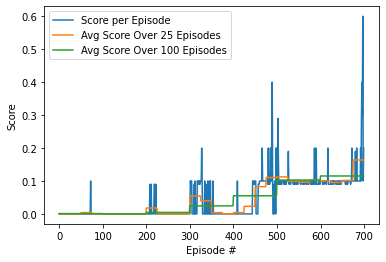

In [10]:
import matplotlib.pyplot as plt
scores_train = scores
# get scores averages over x episodes
averages_num = []
averages_100 = []
score_sum = 0
score_sum_100 = 0
i = 1
x_episodes = 25
for score in scores:
    score_sum+=score
    score_sum_100+=score
    if i%x_episodes == 0:
        score_sum = score_sum/x_episodes
        for j in range(0,x_episodes):
            averages_num.append(score_sum)
        if i%100 == 0:
            score_sum_100 = score_sum_100/100
            for j in range(0,100):
                averages_100.append(score_sum_100)
            score_sum_100 = 0
        score_sum=0
    i+=1

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score per Episode')
plt.plot(np.arange(len(averages_num)), averages_num, label='Avg Score Over ' +str(x_episodes)+ ' Episodes')
plt.plot(np.arange(len(averages_100)), averages_100, label='Avg Score Over 100 Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [11]:
torch.save(agent.actor_local.state_dict(), 'agent_checkpoints/actor_checkpoint.pth')
torch.save(agent.critic_local.state_dict(), 'agent_checkpoints/critic_checkpoint.pth')

## Test Agent

In [16]:
# load the weights from file
#agent = Agent(state_size=state_size, action_size=action_size)
#fromMemory = input("Do you want to test using network from memory? 0-Yes 1-No ")
fromMemory = 1
if fromMemory == "0":
    print("Continuing from Memory...")
    #agent = torch.load('agent.pth',map_location=torch.device('cpu'))
    agent.actor_local.load_state_dict(torch.load('actor_checkpoint.pth',map_location=torch.device('cpu')))
    agent.critic_local.load_state_dict(torch.load('critic_checkpoint.pth',map_location=torch.device('cpu')))
else:
    print("Using the current trained network. If no one has previously been trained agent will act randomly.")
agent.actor_local.eval()
agent.critic_local.eval()
max_t = 1000
scores_test = []

test_episodes = 2
for episode in range(test_episodes):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations   # get the next state
    scores = [0,0]
    for t in range(max_t):
        
        action0 = agent.act(states[0])
        action1 = agent.act(states[1])
        actions = [action0,action1]
        env_info = env.step(actions)[brain_name]

        states = env_info.vector_observations   # get the next state
        rewards = env_info.rewards                   # get the reward
        dones = env_info.local_done
        scores = [sum(i) for i in zip(scores, rewards)]  
        if dones[0] is True or dones[1] is True:
            break 
    scores_test.append(max(scores))
    print("Episode: " + str(episode+1) + " Score: " + str(max(scores)))
            

Using the current trained network. If no one has previously been trained agent will act randomly.
Episode: 1 Score: 2.600000038743019
Episode: 2 Score: 2.1000000312924385


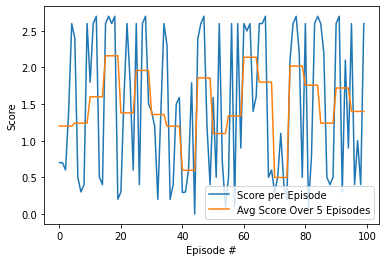

Avg Score Over All Episodes - 1.478200022056699


In [14]:
import matplotlib.pyplot as plt

# get scores averages over x episodes
averages_test = []
score_sum_test = 0
i = 1
test_episodes_avg = 5
for score in scores_test:
    score_sum_test+=score
    if i%test_episodes_avg == 0:
        score_sum_test = score_sum_test/test_episodes_avg
        for j in range(0,test_episodes_avg):
            averages_test.append(score_sum_test)
        score_sum_test=0
    i+=1

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_test)), scores_test, label='Score per Episode')
plt.plot(np.arange(len(averages_test)), averages_test, label='Avg Score Over ' +str(test_episodes_avg)+ ' Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

print('Avg Score Over All Episodes - ' + str(sum(averages_test)/len(averages_test)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```